In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from scipy.optimize import curve_fit
import straxbra
from pymongo import MongoClient
import os
import strax
import json
import patrick_stylez as ps

Using TensorFlow backend.


In [2]:
ctx = straxbra.XebraContext(register=[straxbra.plugins.DAQReader],
                            config={'do_breaks' : False})
all_gains = {}

In [7]:
def gaus(x, mu, sig, amp):
    amp = max(1, amp)
    sig = max(1, sig)
    log_scale = np.log(amp) - 0.5*np.log(2*np.pi) - np.log(sig)
    log_exp = -(x - mu)**2/(2*sig**2)
    return np.exp(log_scale + log_exp)

def fit_fcn(x, *args):
    noise = list(args[0:3])
    s = gaus(x, *noise)
    spe = list(args[3:6])
    #spe[2] = spe[2]*noise[2]
    s += gaus(x, *spe)
    if len(args) > 6:
        dpe = list(args[6:9])
        dpe[0] = spe[0]*dpe[0]
        #dpe[2] = spe[2]*dpe[2]
        s += gaus(x, *dpe)
        if len(args) > 9:
            upe = list(args[9:12])
            upe[0] = upe[0]*spe[0]
            #upe[2] = upe[2]*spe[2]
            s += gaus(x, *upe)
    return s

def PlotForRun(context, run):
    fig, axs = plt.subplots(figsize=(18,12), nrows=3, ncols=3)
    raw = context.get_array(run, 'raw_records')
    
    window_low = 40
    window_high = 65
    
    bin_high = np.zeros(8, int)
    for ch in range(8):
        if(ch==0):
            bin_high[ch] = (np.quantile((raw['data'][raw['channel'] == ch, window_low:window_high].sum(axis=1)),0.998) //100 +1.5)*100
        else:
            bin_high[ch] = (np.quantile((raw['data'][raw['channel'] == ch, window_low:window_high].sum(axis=1)),0.999) //100 +1.5)*100 
        bin_high[ch] = np.amax((bin_high[ch], 250))
    print('bin high: ',bin_high)
    
    colors = ['red', 'green', 'cyan', 'magenta', 'lime', 'orange']
    gains = {
        'bin_centers' : [],
        'histogram' : [],
        'popt' : [],
        'pconv' : [],
        'adc_to_pe' : [],
        'gain' : [],
        'run' : int(run),
    }
    nn = ['Noise mean','Noise sigma', 'Noise counts',
          '1pe mean', '1pe sigma', '1pe counts',
          '2pe mean scale', '2pe sigma', '2pe counts',
          'Uamp mean scale', 'Uamp sigma', 'Uamp counts']
    adc_to_e = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) * (10)
    
    for ch in range(8):
        if(bin_high[ch] > 600):
            bins = np.linspace(-50,bin_high[ch],201) ### use this for LED Cal with x10 Amplifier
        else:
            bins = np.linspace(-50,bin_high[ch],101) ### use this for LED Cal (without x10 Amplifier)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        bin_widths = bins[1:] - bins[:-1]
        ax = axs[ch//3][ch%3]
        
        n, _ = np.histogram(raw['data'][raw['channel'] == ch, window_low:window_high].sum(axis=1), bins=bins)
        sigma = np.maximum(np.ones_like(n), np.sqrt(n)/bin_widths)
        
        n = n/bin_widths
        ax.step(bin_centers, n, where='mid', c='k')
        gains['bin_centers'].append(bin_centers.tolist())
        gains['histogram'].append(n.tolist())
        cts = n.sum()
        
        noise_guess_index = np.argmax(n)
        noise_guess = bin_centers[noise_guess_index]
        spe_guess_index = np.argmax(n[len(bins)//4 :]) + len(bins)//4
        spe_guess = bin_centers[spe_guess_index]
        minimum_guess_index = np.argmin(n[noise_guess_index : np.argmax(n[len(bins)//4 :])+len(bins)//4])
        minimum_guess = bin_centers[minimum_guess_index]
        print ('SPE_guess = %2.2f , Mimimum_guess = %2.2f' %(spe_guess, minimum_guess))
        
        ### Artificial Panelty on the bins before the minimum 
        #for i in range(len(bins)//20):
        #    sigma[minimum_guess_index-len(bins)//20+i] = sigma[minimum_guess_index-len(bins)//20+i]*(i+1)*10
        
        ### Preliminiary fit with noise + spe Gaussian only
        bounds_prelim = np.array([
            [-50,-10,30],  # 0pe mean
            [10, 40, 100],   # 0pe sigma
            [cts/10, cts, cts*100], # 0pe counts
            [0.95*spe_guess, spe_guess, 6*spe_guess], # 1pe mean
            [0.2*spe_guess, spe_guess*0.5, 1.0*spe_guess], # 1pe sigma
            [cts/1e8, cts/1e1, cts/1e0], # 1pe counts
        ])            
        if(ch == 0):
            bounds_prelim[3] =  bounds_prelim[3] /2
        
        popt_prelim, pconv_prelim = curve_fit(fit_fcn, bin_centers, n, p0=bounds_prelim[:,1], sigma=sigma, bounds=bounds_prelim[:,[0,2]].T)
        
        ### Final fit with noise, spe, dpe & uamp contributions, based on preliminar fit results
        bounds = np.array([
            [popt_prelim[0] - 3* popt_prelim[1], popt_prelim[0],popt_prelim[0] + 3* popt_prelim[1]],  # 0pe mean
            [popt_prelim[1]/2, popt_prelim[1], popt_prelim[1]*2],   # 0pe sigma
            [popt_prelim[2]/5, popt_prelim[2], popt_prelim[2]*5], # 0pe counts
            [popt_prelim[3]*0.95, popt_prelim[3], popt_prelim[3]*4], # 1pe mean
            [popt_prelim[4]/2, popt_prelim[4], popt_prelim[4]*2], # 1pe sigma
            [popt_prelim[5]/1000, popt_prelim[5]/2, popt_prelim[5]*10], # 1pe counts
            [1.8, 2, 2.4], # 2pe mean scale factor
            [popt_prelim[4], popt_prelim[4]*1.4, popt_prelim[4]*1.8], # 2pe sigma
            [(popt_prelim[5]**2/ popt_prelim[2]) / 10, (popt_prelim[5]**2/ popt_prelim[2]), (popt_prelim[5]**2/ popt_prelim[2]) *10], # 2pe counts
            [(popt_prelim[0] + popt_prelim[1] )/ popt_prelim[3], 0.2, (popt_prelim[0] + 3* popt_prelim[1])/ popt_prelim[3] ], # underamp mean scale factor
            [1, 10, np.amin((50, popt_prelim[1]))], # underamp sigma
            [cts/1e6, cts/1e4, cts/3e1], # underamp counts
        ])
        try:
            popt, pconv = curve_fit(fit_fcn, bin_centers, n, p0=bounds[:,1],sigma=sigma, bounds=bounds[:,[0,2]].T)
            print('CH%i Xsq/NDF: %.3g/%.3g' % (ch,(((n-fit_fcn(bin_centers, *popt))/sigma)**2).sum(), len(n) - len(popt)))
            for a in zip(nn, popt, np.sqrt(np.diag(pconv))):
                print('CH%i: %s: %.3g +- %.3g' % (ch, *a))
            print()
            ax.plot(bin_centers, fit_fcn(bin_centers, *popt), linestyle='--', c='b')
            ax.plot(bin_centers, gaus(bin_centers, *popt[0:3]), c=colors[0], label = 'noise')  # noise
            ax.plot(bin_centers, gaus(bin_centers, *popt[3:6]), c=colors[1], label = 'single-pe')  # spe
            ax.plot(bin_centers, gaus(bin_centers, popt[6]*popt[3], popt[7], popt[8]), c=colors[2], label = 'double-pe')  # dpe
            ax.plot(bin_centers, gaus(bin_centers, popt[9]*popt[3], popt[10], popt[11]), c=colors[3], label = 'underampl.')  # upe
            ax.set_ylim(0.3,popt[2]/10)
            gains['popt'].append(popt.tolist())
            gains['pconv'].append(pconv.tolist())
            gains['adc_to_pe'].append(1./popt[3])
            gains['gain'].append(popt[3]*adc_to_e)
            print('what is this value:', 1./popt[3])
                       
        except Exception as e:
            print('CH%i failed\n' % ch)
            ax.plot(bin_centers, fit_fcn(bin_centers, *bounds[:,1]), linestyle='--', c='b')
            ax.set_ylim(0.3, bounds[2,1]/10)
            gains['popt'].append(bounds[:,1].tolist())
            gains['pconv'].append(-1),
            gains['adc_to_pe'].append(0)
            gains['gain'].append(0)

        ax.set_yscale('log')
        ax.set_xlim(bins[0], bins[-1])
        ax.set_title('LED - Run: ' + run + ' - Channel: %i' %ch)
        ax.legend()
        #fig.savefig(f'gainplots/{run}.png', bbox_inches='tight')
    axs[2,2].set_title(run)
     

        
    plt.show()
    print(gains)
    return gains

bin high:  [250 250 250 350 250 250 250 250]
SPE_guess = 26.50 , Mimimum_guess = -15.50
CH0 Xsq/NDF: 5.03e+03/88
CH0: Noise mean: -10.8 +- 0.0925
CH0: Noise sigma: 14.2 +- 0.0687
CH0: Noise counts: 2.99e+06 +- 1.62e+04
CH0: 1pe mean: 34.4 +- 4.14
CH0: 1pe sigma: 13.3 +- 2.79
CH0: 1pe counts: 2.08e+04 +- 6.68e+03
CH0: 2pe mean scale: 2.4 +- 0.841
CH0: 2pe sigma: 47.7 +- 15.1
CH0: 2pe counts: 9.41e+03 +- 4.09e+03
CH0: Uamp mean scale: 0.189 +- 1.31e+04
CH0: Uamp sigma: 1 +- 4.6e+05
CH0: Uamp counts: 1 +- 4.65e+05

what is this value: 0.029093862020221427
SPE_guess = 26.50 , Mimimum_guess = -12.50
CH1 Xsq/NDF: 6.6e+03/88
CH1: Noise mean: -12.2 +- 0.104
CH1: Noise sigma: 10.9 +- 0.068
CH1: Noise counts: 2.99e+06 +- 2.08e+04
CH1: 1pe mean: 50.5 +- 9.4
CH1: 1pe sigma: 31.5 +- 13.8
CH1: 1pe counts: 9.85e+03 +- 7.64e+03
CH1: 2pe mean scale: 2.4 +- 23.8
CH1: 2pe sigma: 47.7 +- 516
CH1: 2pe counts: 255 +- 6.17e+03
CH1: Uamp mean scale: 0.151 +- 0.0343
CH1: Uamp sigma: 4.02 +- 1.06
CH1: Uamp coun

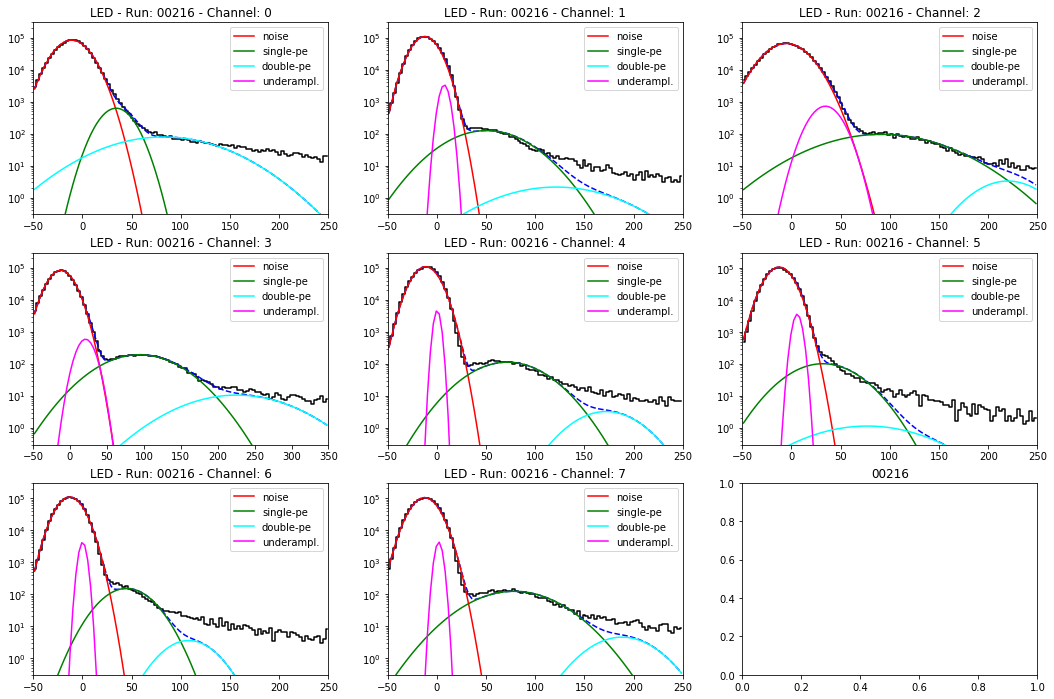

{'bin_centers': [[-48.5, -45.5, -42.5, -39.5, -36.5, -33.5, -30.5, -27.5, -24.5, -21.5, -18.5, -15.5, -12.5, -9.5, -6.5, -3.5, -0.5, 2.5, 5.5, 8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5, 29.5, 32.5, 35.5, 38.5, 41.5, 44.5, 47.5, 50.5, 53.5, 56.5, 59.5, 62.5, 65.5, 68.5, 71.5, 74.5, 77.5, 80.5, 83.5, 86.5, 89.5, 92.5, 95.5, 98.5, 101.5, 104.5, 107.5, 110.5, 113.5, 116.5, 119.5, 122.5, 125.5, 128.5, 131.5, 134.5, 137.5, 140.5, 143.5, 146.5, 149.5, 152.5, 155.5, 158.5, 161.5, 164.5, 167.5, 170.5, 173.5, 176.5, 179.5, 182.5, 185.5, 188.5, 191.5, 194.5, 197.5, 200.5, 203.5, 206.5, 209.5, 212.5, 215.5, 218.5, 221.5, 224.5, 227.5, 230.5, 233.5, 236.5, 239.5, 242.5, 245.5, 248.5], [-48.5, -45.5, -42.5, -39.5, -36.5, -33.5, -30.5, -27.5, -24.5, -21.5, -18.5, -15.5, -12.5, -9.5, -6.5, -3.5, -0.5, 2.5, 5.5, 8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5, 29.5, 32.5, 35.5, 38.5, 41.5, 44.5, 47.5, 50.5, 53.5, 56.5, 59.5, 62.5, 65.5, 68.5, 71.5, 74.5, 77.5, 80.5, 83.5, 86.5, 89.5, 92.5, 95.5, 98.5, 101.5, 104

In [8]:
run = '00216'
gaindoc = PlotForRun(ctx, run)

# second attempt

In [5]:
def gaus(x, mu, sig, amp):
    amp = max(1, amp)
    sig = max(1, sig)
    log_scale = np.log(amp) - 0.5*np.log(2*np.pi) - np.log(sig)
    log_exp = -(x - mu)**2/(2*sig**2)
    return np.exp(log_scale + log_exp)

def noise_fit_fcn(x, *args):
    noise = list(args[0:3])
    s = gaus(x, *noise)
    if len(args) >3:
        upe = list(args[3:6])
        s += gaus(x, *upe)
    return s
    
def signal_fit_fcn(x, *args):
    spe = list(args[0:3])
    s = gaus(x, *spe)
    if len(args) > 3:
        dpe = list(args[3:6])
        dpe[0] = spe[0]*dpe[0]
        #dpe[2] = spe[2]*dpe[2]
        s += gaus(x, *dpe)
        if len(args) > 6:
            tpe = list(args[6:9])
            tpe[0] = tpe[0]*spe[0]
            s += gaus(x, *tpe)
    return s


def PlotForRun_V2(context, run):
    fig, axs = plt.subplots(figsize=(18,12), nrows=3, ncols=3)
    raw = context.get_array(run, 'raw_records')
    
    window_low = 40
    window_high = 65
    
    bin_high = np.zeros(8, int)
    for ch in range(8):
        if(ch==0 or ch==5):
            bin_high[ch] = (np.quantile((raw['data'][raw['channel'] == ch, window_low:window_high].sum(axis=1)),0.998) //100 +1.5)*100
        else:
            bin_high[ch] = (np.quantile((raw['data'][raw['channel'] == ch, window_low:window_high].sum(axis=1)),0.9995) //100 +1.5)*100 

    print(bin_high)
    
    colors = ['red', 'green', 'cyan', 'magenta', 'lime', 'orange']
    gains = {
        'bin_centers' : [],
        'histogram' : [],
        'popt' : [],
        'pconv' : [],
        'adc_to_pe' : [],
        'gain' : [],
        'run' : int(run),
    }
    nn = ['Noise mean','Noise sigma', 'Noise counts',
          '1pe mean', '1pe sigma', '1pe counts',
          '2pe mean scale', '2pe sigma', '2pe counts',
          'Uamp mean scale', 'Uamp sigma', 'Uamp counts']
    adc_to_e = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) * (10)
    
    for ch in range(8):
        if(bin_high[ch] > 600):
            bins = np.linspace(-50,bin_high[ch],201) 
        else:
            bins = np.linspace(-50,bin_high[ch],101) 
            
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        bin_widths = bins[1:] - bins[:-1]
        ax = axs[ch//3][ch%3]
        
        n, _ = np.histogram(raw['data'][raw['channel'] == ch, window_low:window_high].sum(axis=1), bins=bins)
        sigma = np.maximum(np.ones_like(n), np.sqrt(n)/bin_widths)
        
        n = n/bin_widths
        ax.step(bin_centers, n, where='mid', c='k')
        gains['bin_centers'].append(bin_centers.tolist())
        gains['histogram'].append(n.tolist())
        cts = n.sum()
        
        noise_guess_index = np.argmax(n)
        noise_guess = bin_centers[noise_guess_index]
        
        if(ch == 0):
            spe_guess_index = np.argmax(n[len(bins)//6 :]) + len(bins)//6
        else:
            spe_guess_index = np.argmax(n[len(bins)//4 :]) + len(bins)//4
        spe_guess = bin_centers[spe_guess_index]

        minimum_guess_index = np.argmin(n[: spe_guess_index])
        minimum_guess = bin_centers[minimum_guess_index]
        #print ('CH %i: SPE_guess = %2.2f , Mimimum_guess = %2.2f, noise_guess = %2.2f' %(ch, spe_guess, minimum_guess, noise_guess))
        #print ('CH %i: SPE_guess_index = %i , Mimimum_guess_index = %i, noise_guess_index = %i' %(ch, spe_guess_index, minimum_guess_index, noise_guess_index))

        
        
        ### Fit with noise, upe as well as spe, dpe & tpe in separate ranges
        bounds_noise = np.array([
            [-50, noise_guess,minimum_guess],  # 0pe mean
            [1, (minimum_guess - noise_guess)/3, minimum_guess - noise_guess],   # 0pe sigma
            [cts/100, cts, cts*100]  # 0pe counts
            #,
            #[0, noise_guess + (minimum_guess - noise_guess)/2, minimum_guess], # underamp mean
            #[1, 5, (minimum_guess - noise_guess)/2], # underamp sigma
            #[cts/1e6, cts/1e3, cts/1e1] # underamp counts
        ])
        bounds_signal_prelim=np.array([
            [minimum_guess, spe_guess, spe_guess*3], # SPE mean
            [0.1 * spe_guess, 0.6 * spe_guess, spe_guess*3], # SPE sigma
            [cts/1e6, cts /1e3, cts ]
        ])

        
        popt_noise, pconv_noise = curve_fit(noise_fit_fcn, bin_centers[: minimum_guess_index], n[: minimum_guess_index], p0=bounds_noise[:,1], sigma=sigma[: minimum_guess_index], bounds=bounds_noise[:,[0,2]].T)
        popt_signal_prelim, pconv_signal_prelim = curve_fit(signal_fit_fcn, bin_centers[minimum_guess_index :], n[minimum_guess_index :], p0=bounds_signal_prelim[:,1], sigma=sigma[minimum_guess_index :], bounds=bounds_signal_prelim[:,[0,2]].T)

        
        bounds_signal=np.array([
            [popt_signal_prelim[0]*0.8, popt_signal_prelim[0], popt_signal_prelim[0]*1.2], # SPE mean
            [popt_signal_prelim[1]/2, popt_signal_prelim[1], popt_signal_prelim[1] *2], # SPE sigma
            [popt_signal_prelim[2]/2, popt_signal_prelim[2], popt_signal_prelim[2]*2 ], # SPE counts
            [popt_signal_prelim[0]*1.8, popt_signal_prelim[0]*2, popt_signal_prelim[0]*2.2], # DPE mean
            [popt_signal_prelim[1]*1, popt_signal_prelim[1]*1.4, popt_signal_prelim[1] *1.8], # DPE sigma
            [popt_signal_prelim[2]**2 / popt_noise[2]/100 , popt_signal_prelim[2]**2 / popt_noise[2], popt_signal_prelim[2]**2 / popt_noise[2]*100], # DPE counts
            [popt_signal_prelim[0]*2.6, popt_signal_prelim[0]*3, popt_signal_prelim[0]*3.4], # DPE mean
            [popt_signal_prelim[1]*1, popt_signal_prelim[1]*1.7, popt_signal_prelim[1] *2], # DPE sigma
            [popt_signal_prelim[2]**3 / popt_noise[2]**2 /100 , popt_signal_prelim[2]**3 / popt_noise[2]**2, popt_signal_prelim[2]**3 / popt_noise[2]**2 *100] # DPE counts

        ])
        
        popt_signal, pconv_signal = curve_fit(signal_fit_fcn, bin_centers[minimum_guess_index :], n[minimum_guess_index :], p0=bounds_signal[:,1], sigma=sigma[minimum_guess_index :], bounds=bounds_signal[:,[0,2]].T)

        ax.plot(bin_centers, (noise_fit_fcn(bin_centers, *popt_noise) + signal_fit_fcn(bin_centers, *popt_signal)), linestyle='--', c='b')
        ax.plot(bin_centers, gaus(bin_centers, *popt_noise[0:3]), c=colors[0], label = 'noise')  
        if len(bounds_noise) > 3: 
            ax.plot(bin_centers, gaus(bin_centers, *popt_noise[3:6]), c=colors[3], label = 'underampl.')  
        
        ax.plot(bin_centers, gaus(bin_centers, *popt_signal[0:3]), c=colors[1], label = 'single-pe')
        if len(bounds_signal) > 3:
            ax.plot(bin_centers, gaus(bin_centers, *popt_signal[3:6]), c=colors[2], label = 'double-pe')
            if len(bounds_signal) > 6: 
                ax.plot(bin_centers, gaus(bin_centers, *popt_signal[6:9]), c=colors[4], label = 'triple-pe')

        ax.set_ylim(0.3,popt_noise[2]/10)
        
        ax.set_yscale('log')
        ax.set_xlim(bins[0], bins[-1])
        ax.set_title('LED - Run: ' + run + ' - Channel: %i' %ch)
        #ax.legend()
        #fig.savefig(f'gainplots/{run}.png', bbox_inches='tight')
    axs[2,2].set_title(run)
            
    plt.show()
    return 

[150 250 250 450 250 150 250 250]


ValueError: `xdata` must not be empty!

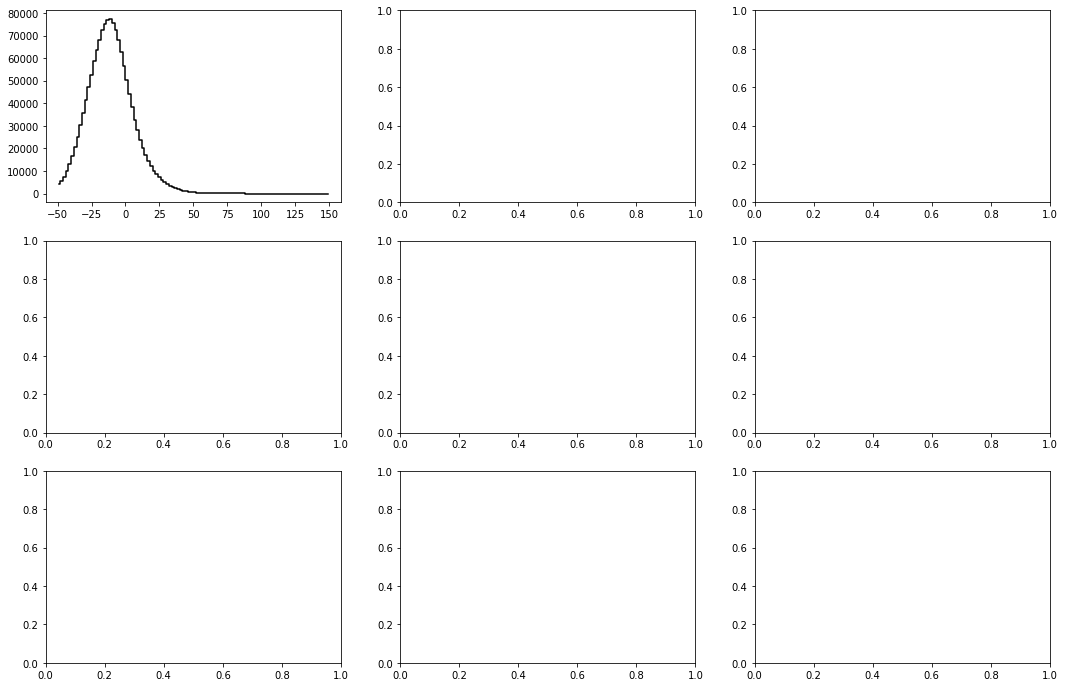

In [6]:
run = '00212'
gaindoc = PlotForRun_V2(ctx, run)